## Introduction to the Data Set

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [1]:
import pandas as pd

bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here are the descriptions for the relevant columns:

- `instant` - A unique sequential ID number for each row
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred
- `yr` - The year the rentals occurred
- `mnth` - The month the rentals occurred
- `hr` - The hour the rentals occurred
- `holiday` - Whether or not the day was a holiday
- `weekday` - The day of the week (as a number, 0 to 7)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather (as a categorical variable)
- `temp` - The temperature, on a 0-1 scale
- `atemp` - The adjusted temperature
- `hum` - The humidity, on a 0-1 scale
- `windspeed` - The wind speed, on a 0-1 scale
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (casual + registered)

In this project, we will try to predict the total number of bikes people rented in a given hour. We will predict the `cnt` column using all of the other columns, except for `casual` and `registered`.

In [2]:
print(bike_rentals.shape)
print('-'*20)
bike_rentals.info() #observing column type and for null values

(17379, 17)
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


There are no null values and all columns are numeric, except the dates.

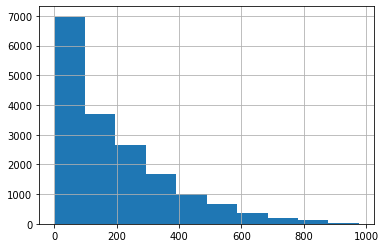

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

bike_rentals['cnt'].hist()

In [4]:
cnt_corr = bike_rentals.corr()['cnt']
cnt_corr

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Calculating Features

The `hr` column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We will introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night.

In [5]:
def assign_label(hour):
    if hour >= 0 and hour < 6:
        return 4
    elif hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <= 24:
        return 3
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

## Creating Train & Test Data sets

### Error Metric

Based on our explorations of the `cnt` column, we will choose the `mean squared error` to use to evaluate the performance of the machine learning algorithms.

In [6]:
train = bike_rentals.sample(frac = 0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

drop_cols = ['instant', 'dteday', 'casual', 'registered', 'cnt']
linear_train = train.drop(columns = drop_cols)
features = linear_train.columns.tolist()
features

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [8]:
lr = LinearRegression()
lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])

In [9]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test['cnt'], predictions)
error

16951.69198051668

The error is very high. MSE always emphasizes significant errors as bigger. We will have to try different approaches to lower the MSE.

## Decision Trees

In [10]:
from sklearn.tree import DecisionTreeRegressor

n_leaves = [1, 2, 5, 10, 20]
mses = []
for n in n_leaves:
    dtr = DecisionTreeRegressor(min_samples_leaf = n, random_state = 2)
    dtr.fit(train[features], train['cnt'])
    predictions = dtr.predict(test[features])
    mse = mean_squared_error(test['cnt'], predictions)
    mses.append(mse)

mses_dict = {}
for n, mse in zip(n_leaves, mses):
    mses_dict[n] = mse

mses_dict

{1: 3243.704401611047,
 2: 2861.8798067702337,
 5: 2539.3596871245804,
 10: 2667.555198709208,
 20: 3086.2142829192}

Decision Tree regressor has much lower error than the Linear Regressor. This is because the descision tree regressor can account for non linearity in the data.

After, experimenting with different inputs for the `min_samples_leaf` parameter. We seem to get the lowest mse when `min_samples_leaf = 5`.

## Random Forests

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

hyperparameters = {'max_depth' : [None, 5, 10],
                   'min_samples_leaf' : [1, 5, 10],
                   'n_estimators' : [10, 20]
                  }
rf = RandomForestRegressor(random_state = 2)
grid = GridSearchCV(rf, param_grid = hyperparameters, cv = 10)
grid.fit(bike_rentals[features], bike_rentals['cnt'])

grid.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 20}

In [12]:
best_rf = grid.best_estimator_
best_rf.fit(train[features], train['cnt'])
predictions = best_rf.predict(test[features])
mse = mean_squared_error(test['cnt'], predictions)

mse

1776.8614996234096

The lowest MSE of around 1700 was acheived through Random Forest Regressor and model tuning. With 20 decision trees in the forest(`n_estimators = 20`) the accuracy has increased as overfitting is reduced. 

---
## Conclusion

We see an improvement of the error as we utilize Random Forest model with hyperparameter optimization. 

There is still room for lowering the MSE by:

- creating additional features, such as combining humidity, temperature and wind speed.
- utilizing Neural Network models (deep learning).

It would also be interesting to predict the `casual` and `registered` rentals instead of `cnt` and see how they differ.